# Preparing Simulation Data
> Notebook for preparing synthetic datasets. This data will be called as a "raw data" in other notebooks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

from vertex_simulation.primitives import unit_hexagons, VoronoiRegions2Edges, Vertex, Monolayer
from vertex_simulation.simulation import Simulation_Honda, Simulation_Honda_t
from vertex_simulation.primitives import plot_graph_as_quiver, graph2networkx_with_pos
import networkx as nx
from simgnn.datautils import *

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Raw Synthetic Dataset

Initialising cell monolayers

In [5]:
v_x,regions = unit_hexagons(3,3) # unit hexagons
edge_list,cells = VoronoiRegions2Edges(regions) #convert Voronoi regions to cells & edges

m = Monolayer(vertices = Vertex( v_x.copy().tolist(), dtype = dtype), edges = torch.tensor(edge_list), cells = cells)
m.to_(device) # to plot use --> plot_graph_as_quiver(cell_graph)

### Plotting Monolayer Graphs

Using `plot_graph_as_quiver`

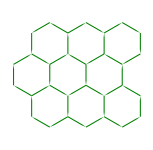

In [6]:
plt.figure(figsize=[2.5,2.5])
plot_graph_as_quiver(m)
plt.axis('equal');

Convert to `networkx.Graph` with `graph2networkx_with_pos` and use `networkx.draw` function

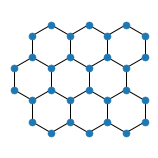

In [7]:
plt.figure(figsize=[2,2])
nx.draw(*graph2networkx_with_pos(m), node_size=50, width=1)
plt.axis('equal');

### Simulation

Prepare an initial state

- 17Nov2020: np seed 42, 10x10 cells, torch seed 0
- 22Dec2020: np seed 24, 8x8 cells, torch seed 42

In [4]:
np.random.seed(24)# np RNG seed

v_x,regions = unit_hexagons(8,8) # unit hexagons
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2 #perturb vertices
edge_list,cells = VoronoiRegions2Edges(regions) #convert Voronoi regions to cells & edges
# Define cell monolayer
m = Monolayer(vertices = Vertex( v_x.copy().tolist(), dtype = dtype), edges = torch.tensor(edge_list), cells = cells)


- use the cell below for plotting `m`

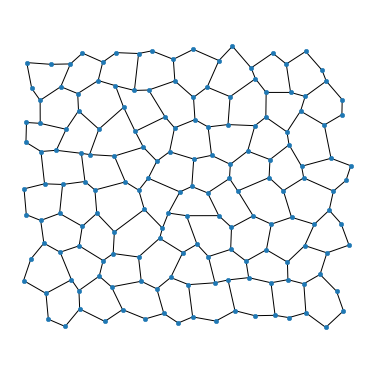

In [5]:
plt.figure(figsize=[5,5])
nx.draw(*graph2networkx_with_pos(m), node_size=20, width=1)
plt.axis('equal');
plt.axis(False);
# plt.savefig('./sim_ocsill_10x10.png',dpi=100)

In [11]:
# np.random.seed(21)
# Dt=0.001
# # t_tot = 5000
# t_unit = 1/Dt # t_start + 1/Dt
# t = np.linspace(0,t_unit*10,1000)*Dt

# N=3
# # omega0 = np.random.randint(0,5,size=(N,))# number of full peaks per-unit-of-time
# omega0 = np.random.random_sample(size=(N,))*0.6
# phase0 = np.random.random_sample(size=(N,))*0.5 # phase in [0, 1/2] * pi

# plt.figure(figsize=[8,4.5])
# for w,phi in zip(omega0,phase0):
#     plt.plot(t,np.cos(w*np.pi*t+np.pi*phi)**2,lw=4, label=f'$\omega={w:.1f}\pi$; $\phi={phi:.1f}\pi$',alpha=.5)
# plt.legend()
# plt.xlabel('Time [min]');plt.ylabel('$Cos^2(\omega t+\phi)$')

# # plt.savefig('oscillation_peaks_small.png',dpi=100)
# plt.show()

Base frequency selection for $cos^2(wt)$:
$$\omega = peaks\_per\_unit\_time \times \pi$$
e.g. for 5 peaks per-unit-time $\omega_0 = 5 \pi$. We can add random number (real number) of peaks to this "base frequency":
- For $N_{max}$ peaks as threshold, I can sample:
$$\omega\sim Unif(0,N_{max}\cdot \pi)$$
- Phases ($\phi$) determine value at $t=0$ for $cos^2(wt+\phi) \in [0,1]$ 
$$\phi \sim Unif(0,\frac{\pi}{2}) $$
<!-- ![]('./oscillation_peaks_small.png') -->
<img src="./oscillation_peaks_small.png" width=512>
- I can also sample amplitudes, currently it is set to constant 2.5 ({0:off, 2.5:on})

My plan is to implement junctional oscillations as $L_{ij}(t)=cos^2(\omega_{ij}t+\phi_{ij})$ in potential energy:

$$Energy=\sum_{cells: i}K_a(A_i-A_i^0)^2 + K_p(P_i-P_i^0)^2 + \sum_{edges:ij}\Lambda_{ij}(t)\cdot len_{ij}$$

where $\Lambda_{ij}(t)=\lambda_{ij}\cdot L_{ij}(t)$ is the "contractility".

*Assumptions*:
1. Ka, A0, Kp, P0 are cell type specific and constant for the duration of simulation.
    - i.e. {Ka, A0, Kp, P0} are same for all cells in a tissue and do not change in time.
2. $\lambda_{ij}$ are constant in time.
2. Ai, Pi, Lij and lengths are NOT constant and change in time.
    - Areas, perimeters, and lengths $\{A_i, P_i, len_{ij}\}_{cells}$ change passively.
    - Lij depends on time (now only time, and could depend on the edge length and vertex positions in the future simulations)

Driving/restoring force $F^{(r)}_{ij}$ acts against the tension $T_{ij}$ acting on an edge `(i,j)`
$$F^{(r)}_{ij}=-T_{ij}=-\frac{\partial Energy(x,t)}{\partial l_{ij}}$$
$$T_{ij} = \Lambda_{ij}(t)+2K_p(P_i-P_i^0)+2K_p(P_j-P_j^0)$$

$T_{ij}$ means tension, which is acting against the "driving" force ($F^{(r)}_{ij}$) to contract the edge `(i,j)`

Pressure (restoring force for area/volume)
$$\pi_i=-\frac{\partial Energy(x,t)}{\partial A_i}$$
$$\pi_i = - 2K_a(A_i-A_i^0)$$

In [12]:
# # Sampling P0's (or A0's)
# plt.hist(torch.normal(mean=0.0,std=.1,size=(len(m.cells),) ).clamp_(0,5));

In [6]:
torch.manual_seed(42);

# Amplitudes ~ Normal(mu=2.1,s.d.=.5) [clamped]
amplt = torch.normal(mean=2.1,std=.5,size=(len(edge_list),1) ).clamp_(0,5).type(dtype).to(device)

# p_keep% of edges are active
p_keep = 0.95
ij_on = amplt*(torch.rand_like(amplt)<p_keep)

# oscillation freq-s
# unit_of_time = 1 min = 1/Dt : Dt:simulation time step size
N_peaks_max = 0.6 # maximum number of peaks per unit of time
omega = N_peaks_max*np.pi*torch.rand_like(ij_on) # in [0, N_peaks_max*pi]
# Phase --> cos2 value at t=0
phases = 0.5*np.pi*torch.rand_like(ij_on) # in [0, 0.5*pi]


def Ka_t(mg,t): return 1.
# def A0_t(mg,t):
#     if t<0.5: C = 1.5
#     else: C = 2.3
#     return C - 1./ (1 + np.exp(20*(t-0.3)) ) 
def A0_t(mg,t): return 2.3
def Kp_t(mg,t): return 0.003
def P0_t(mg,t): return 0.
def Lambda_t(mg,t): return ij_on**torch.cos(omega*t+phases)**2

In [7]:
sim_params = {'Ka':Ka_t, 'A0':A0_t, 'Kp':Kp_t, 'P0':P0_t, 'Lambda_ij':Lambda_t}

m.vertices.requires_grad_(True) # grad tracking
m.to_(device) # to cuda or cpu
sim = Simulation_Honda_t(m = m, params = sim_params)

t, verts_t, Energies_maxSpeeds = sim.sample_trajectory(T=10000, delta_T=0.001, sample_freq=100, print_freq=100)

# convert torch.Tensors to [Time x Vertices x 2] numpy array
# verts_t = np.array([vt.numpy() for vt in verts_t])

iter:100; t=0.099: E=299.4; max_spd = 2.6
iter:200; t=0.199: E=274.4; max_spd =   2
iter:300; t=0.299: E=257.9; max_spd = 1.9
iter:400; t=0.399: E=247.3; max_spd = 1.8
iter:500; t=0.499: E=241.2; max_spd = 2.2
iter:600; t=0.599: E=  239; max_spd = 4.2
iter:700; t=0.699: E=239.4; max_spd = 4.9
iter:800; t=0.799: E=241.4; max_spd = 3.8
iter:900; t=0.899: E=244.2; max_spd = 1.8
iter:1000; t=0.999: E=247.2; max_spd = 3.6
iter:1100; t=1.099: E=  250; max_spd = 1.9
iter:1200; t=1.199: E=252.4; max_spd = 3.1
iter:1300; t=1.299: E=254.4; max_spd = 3.1
iter:1400; t=1.399: E=  256; max_spd = 3.9
iter:1500; t=1.499: E=257.3; max_spd = 4.6
iter:1600; t=1.599: E=257.9; max_spd =   5
iter:1700; t=1.699: E=258.1; max_spd = 4.3
iter:1800; t=1.799: E=257.7; max_spd = 4.4
iter:1900; t=1.899: E=256.9; max_spd = 3.6
iter:2000; t=1.999: E=255.5; max_spd = 3.5
iter:2100; t=2.099: E=  254; max_spd = 3.5
iter:2200; t=2.199: E=252.6; max_spd = 4.6
iter:2300; t=2.299: E=251.6; max_spd =   4
iter:2400; t=2.399: 

Save simulation results and param-s:

In [8]:
dataDir = path.join('../../../dataDIR/simgnn_data/','22Dec2020')
mknewdir(dataDir);

# save simulation results
write_array(path.join(dataDir,'t_Energy_maxSpeed.npy'), np.array(Energies_maxSpeeds))
write_array(path.join(dataDir,'simul_t.npy'), np.array(t))
write_array(path.join(dataDir,'simul_vtxpos.npy'), np.array([vt.numpy() for vt in verts_t]))

# save monolayer's graph and cells
write_graph(path.join(dataDir,'graph_dict.pkl'), m)

# disable grad tracking
m.vertices.requires_grad_(False) # grad tracking
# move to cpu, assuming Simul-n param-s don't depend on vertices
m.to_(torch.device('cpu')) # to cuda or cpu

# cell shape parameters: area, perimeter, edge lengths
cell_params = {k:[] for k in ['Area', 'Perimeter', 'Length']} 
sim_param_vals = {k:[] for k in sim_params.keys()}
# (re-)compute areas and perimeters for sampled frames
for ti,vx in zip(t, verts_t):
    m.vertices.x = vx.cpu() # set new vertex positions
    # cell params for vx, t:
    cell_params['Area'].append(m.area().cpu().numpy())
    cell_params['Perimeter'].append(m.perimeter().cpu().numpy())
    cell_params['Length'].append(m.length().cpu().numpy())
    # simulation params for vx,t (usually depend only on t)
    for k in sim_param_vals:
        # here sim_params[k] doesn't depend on `m`, otherwise compute on "device"
        k_val = sim_params[k](m, ti)
        if isinstance(k_val, torch.Tensor):
            k_val = k_val.cpu().numpy()
        sim_param_vals[k].append(k_val)
        
# maybe can move some of the operations to the "Simulation" class' trajectory sampling
# convert lists of arrays to nd-arrays
cell_params = {k:np.array(cell_params[k]) for k in cell_params}
sim_param_vals = {k:np.array(sim_param_vals[k]) for k in sim_param_vals}

print('Please, re-check and verify that arrays in `sim_param_vals` are saved correctly')

for p in [cell_params, sim_param_vals]:
    # p: parameters (either cell or simulation)
    for k in p:
        # k: name of param
        write_array(path.join(dataDir,f'simul_{k}.npy'),p[k])

Please, re-check and verify that arrays in `sim_param_vals` are saved correctly


In [27]:
# load_array(path.join(dataDir,'t_Energy_maxSpeed.npy')).shape

Loading simulation results and params:

In [37]:
dataDir = path.join('../../../dataDIR/simgnn_data/','22Dec2020')

# save simulation results
Energies_maxSpeeds = load_array(path.join(dataDir,'t_Energy_maxSpeed.npy'))
t = load_array(path.join(dataDir,'simul_t.npy')).tolist()
verts_t = load_array(path.join(dataDir,'simul_vtxpos.npy'))
verts_t = [torch.from_numpy(vx_t) for vx_t in verts_t]

# save monolayer's graph and cells
m_graph = load_graph(path.join(dataDir,'graph_dict.pkl'))
m = Monolayer(vertices=Vertex(verts_t[0]),
          edges=torch.tensor(m_graph['edges'],dtype=torch.long),
         cells = m_graph['cells'])

# # cell shape parameters: area, perimeter, edge lengths
# cell_params = {k:[] for k in ['Area', 'Perimeter', 'Length']} 
# sim_param_vals = {k:[] for k in sim_params.keys()}

# for ti,vx in zip(t, verts_t):
#     m.vertices.x = vx.cpu() # set new vertex positions
#     # cell params for vx, t:
#     cell_params['Area'].append(m.area().cpu().numpy())
#     cell_params['Perimeter'].append(m.perimeter().cpu().numpy())
#     cell_params['Length'].append(m.length().cpu().numpy())
#     # simulation params for vx,t (usually depend only on t)
#     for k in sim_param_vals:
#         # here sim_params[k] doesn't depend on `m`, otherwise compute on "device"
#         k_val = sim_params[k](m, ti)
#         if isinstance(k_val, torch.Tensor):
#             k_val = k_val.cpu().numpy()
#         sim_param_vals[k].append(k_val)

# cell_params = {k:np.array(cell_params[k]) for k in cell_params}
# sim_param_vals = {k:np.array(sim_param_vals[k]) for k in sim_param_vals}

## Saving and Displaying Simulation Movies

`draw_graph`: **Function for plotting frames** (animation function)

In [21]:
import networkx as nx
from vertex_simulation.primitives import graph2networkx_with_pos
# as a networkx graph
Gnx,pos=graph2networkx_with_pos(m)
def draw_graph(i):
    '''Draw monolayer frames using networkx draw func-n. Assumes. Static graph, i.e. the graph `Gnx` is constant.
    We pass this function to matplotlib.animation obj.'''
    if isinstance(verts_t[i],  torch.Tensor):
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    else:
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i]))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {t[i]:5.1f} mins',fontsize=50)
    nx.draw(Gnx,pos,node_size=20,width=8,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')

In [23]:
# Test Drawing one of the frames:

# fig = plt.figure(figsize=[15,15],dpi=40)
# fig.clf()
# ax = fig.subplots()
# ax.axis(False);
# draw_graph(0)
# plt.show()

### Option 1: Use PIL to save as GIF or TIFF

In [24]:
 import PIL
 pil_images=[]
 for i in range(0,len(verts_t),2):
     fig = plt.figure(figsize=[15,15],dpi=40)
     fig.clf()
     ax = fig.subplots()
     ax.axis(False);
     draw_graph(i)
 #     plt.show()
     canvas = plt.get_current_fig_manager().canvas
     canvas.draw()
     pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb()) )
     plt.close()
# duration:duration of each frame [s]
# loop : loop the video, see options
pil_images[0].save('sim_oscill_8x8.gif', format='GIF',
                   append_images=pil_images[1:], save_all=True, duration=150, loop=0)

In [26]:
# ```![](./sim_oscill_10x10.gif)```
from IPython.display import HTML
# HTML('<img src="./sim_oscill_10x10.gif" width=512>')
# HTML('<img src="./sim_oscill_8x8.gif" width=512>')

In [359]:
!ls -lh

total 5.5M
-rw-r--r--. 1 murat team 156K Nov 13  2020 0_synthetic_data.ipynb
-rw-r--r--. 1 murat team 1.6K Nov 13 08:36 1_prepare_dataset.ipynb
-rw-r--r--. 1 murat team  24K Sep  3 06:26 drawing_NNs.ipynb
-rw-r--r--. 1 murat team 106K Nov 13 08:34 oscillation_peaks.png
-rw-r--r--. 1 murat team  68K Nov 13 08:32 oscillation_peaks_small.png
-rw-r--r--. 1 murat team 4.4M Nov 13 03:03 sim_oscill_10x10.gif
lrwxrwxrwx. 1 murat team    7 Sep  3 06:26 src -> ../src/
lrwxrwxrwx. 1 murat team   41 Sep  3 06:26 vertex_simulation -> ../../vertex_simulation/vertex_simulation


### Option 2: HTML video (for displaying) or Save as mp4

Display as HTML video or save as mp4 using matplotlit (+ffmpeg)
```python
import matplotlib.animation as animation
from IPython.display import HTML
# create a figure
fig = plt.figure(figsize=[10,10])
fig.clf()
# display (check your drawing/animation function)
ax = fig.subplots()
ax.axis(False);
draw_graph(0)
plt.show()
plt.close()
# Create an animation
anim = animation.FuncAnimation(fig, draw_graph, interval=200, frames = range(50,len(verts_t)))
# Convert animation to HTML repr-n and display w/ IPython
HTML(anim.to_jshtml()) 
```